In [10]:
import os
import sys
import seawater as sw
from scipy import interpolate as interp

import matplotlib as mpl

sys.path.append("../scripts")
sys.path.append("..")

from extract import *
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)

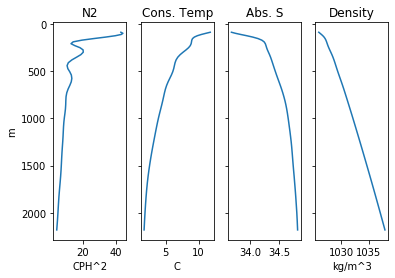

In [2]:
"""
Read data and compute means
"""
path = os.path.join("..","matlab",filename)

table = read_table(path)
N2 = extract_node(table,'N2')
T  = extract_node(table,'T')
W  = extract_node(table,'T')
S  = extract_node(table,'S')
Z  = extract_node(table,'z').flatten()

#Compute the mean stratification
DSL = slice(20,70) # depth slice
N2_mean = np.mean(N2,axis=(0,2,3))
T_mean  = np.mean(T,axis=(0,2,3))
S_mean  = np.mean(S,axis=(0,2,3))
R_mean  = sw.eos80.dens(S_mean[DSL],T_mean[DSL],Z[DSL])

#Plot it
f, ax = plt.subplots(1,4,sharey=True)
ax[0].invert_yaxis()
ax[0].set_title('N2')
ax[0].set_xlabel('CPH^2')
ax[0].set_ylabel('m')
ax[0].plot(3600*np.sqrt(N2_mean[DSL]),Z[DSL])
ax[1].set_title('Cons. Temp')
ax[1].set_xlabel('C')
ax[1].plot(T_mean[DSL],Z[DSL]) 
ax[2].set_title('Salinity')
ax[2].set_title('Abs. S')
ax[2].plot(S_mean[DSL],Z[DSL]) 
ax[3].set_title('Density')
ax[3].set_xlabel('kg/m^3')
ax[3].plot(R_mean,Z[DSL] ) 

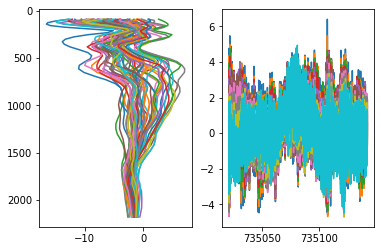

In [4]:
#Define a slice
sl = (slice(0,-1),DSL,slice(0,-1),slice(0,-1))

#Subsample matrices
TP = T[sl]
SP = S[sl]
NP = N2[sl]

TIME   = extract_node(table,'time').flatten()[sl[0]]
LAT    = extract_node(table,'lat')[:,0][sl[2]]
LON    = extract_node(table,'lon')[0,:][sl[3]]
DEPTH  = extract_node(table,'z').flatten()[sl[1]]

#Form a coordinate matrix
AX = np.array(list(itertools.product(*[TIME,DEPTH,LAT,LON])),dtype=[('t',float),('z',float),('x',float),('y',float)])
AX = AX.reshape(TP.shape)

#Compute Density from state variables
RP = sw.eos80.dens(SP,TP,AX['z'])

#Create a function that is depth as a function of the mean density
zofr = interp.InterpolatedUnivariateSpline(R_mean,Z[DSL])
DZ   = zofr(RP) - AX['z']

#Plot anomalies
f,ax = plt.subplots(1,2)
for i in range(50):
    ax[0].plot(DZ[i,:,0,0],AX[i,:,0,0]['z'])

ax[0].invert_yaxis()

for i in range(30,40):
    ax[1].plot(AX[:,i,0,0]['t'],DZ[:,i,0,0] )

In [51]:
sw.eos80.pres(DEPTH,30)  - DEPTH

array([ 0.66558075,  0.7577057 ,  0.83971405,  0.94249725,  1.0565186 ,
        1.1957397 ,  1.3251495 ,  1.4686737 ,  1.6332855 ,  1.7940063 ,
        1.9812622 ,  2.1766052 ,  2.3884583 ,  2.6134033 ,  2.8614197 ,
        3.1070557 ,  3.3703003 ,  3.6626282 ,  3.963684  ,  4.2798767 ,
        4.609314  ,  4.96344   ,  5.3218994 ,  5.7130737 ,  6.1115723 ,
        6.5224    ,  6.9589233 ,  7.416321  ,  7.8928833 ,  8.404297  ,
        8.928894  ,  9.475586  , 10.034912  , 10.631226  , 11.26062   ,
       11.913696  , 12.610474  , 13.328735  , 14.103882  , 14.914429  ,
       15.772339  , 16.675049  , 17.643555  , 18.682983  , 19.781128  ,
       20.977417  , 22.252197  , 23.627075  , 25.110596  , 26.732178  ],
      dtype=float32)

In [14]:
#Depth average time spectrum
DZ_AVG = DZ.mean(axis=(1,2,3))
f,pxx = sig.welch(DZ_AVG,fs=24,nperseg=512)
plt.semilogy(f,pxx)
plt.xlabel('CPD')
plt.ylabel('m^2/cpd')

NameError: name 'DZ' is not defined

Text(0.5, 1.0, 'Spectrum of Depth Average Vertical Velocity')

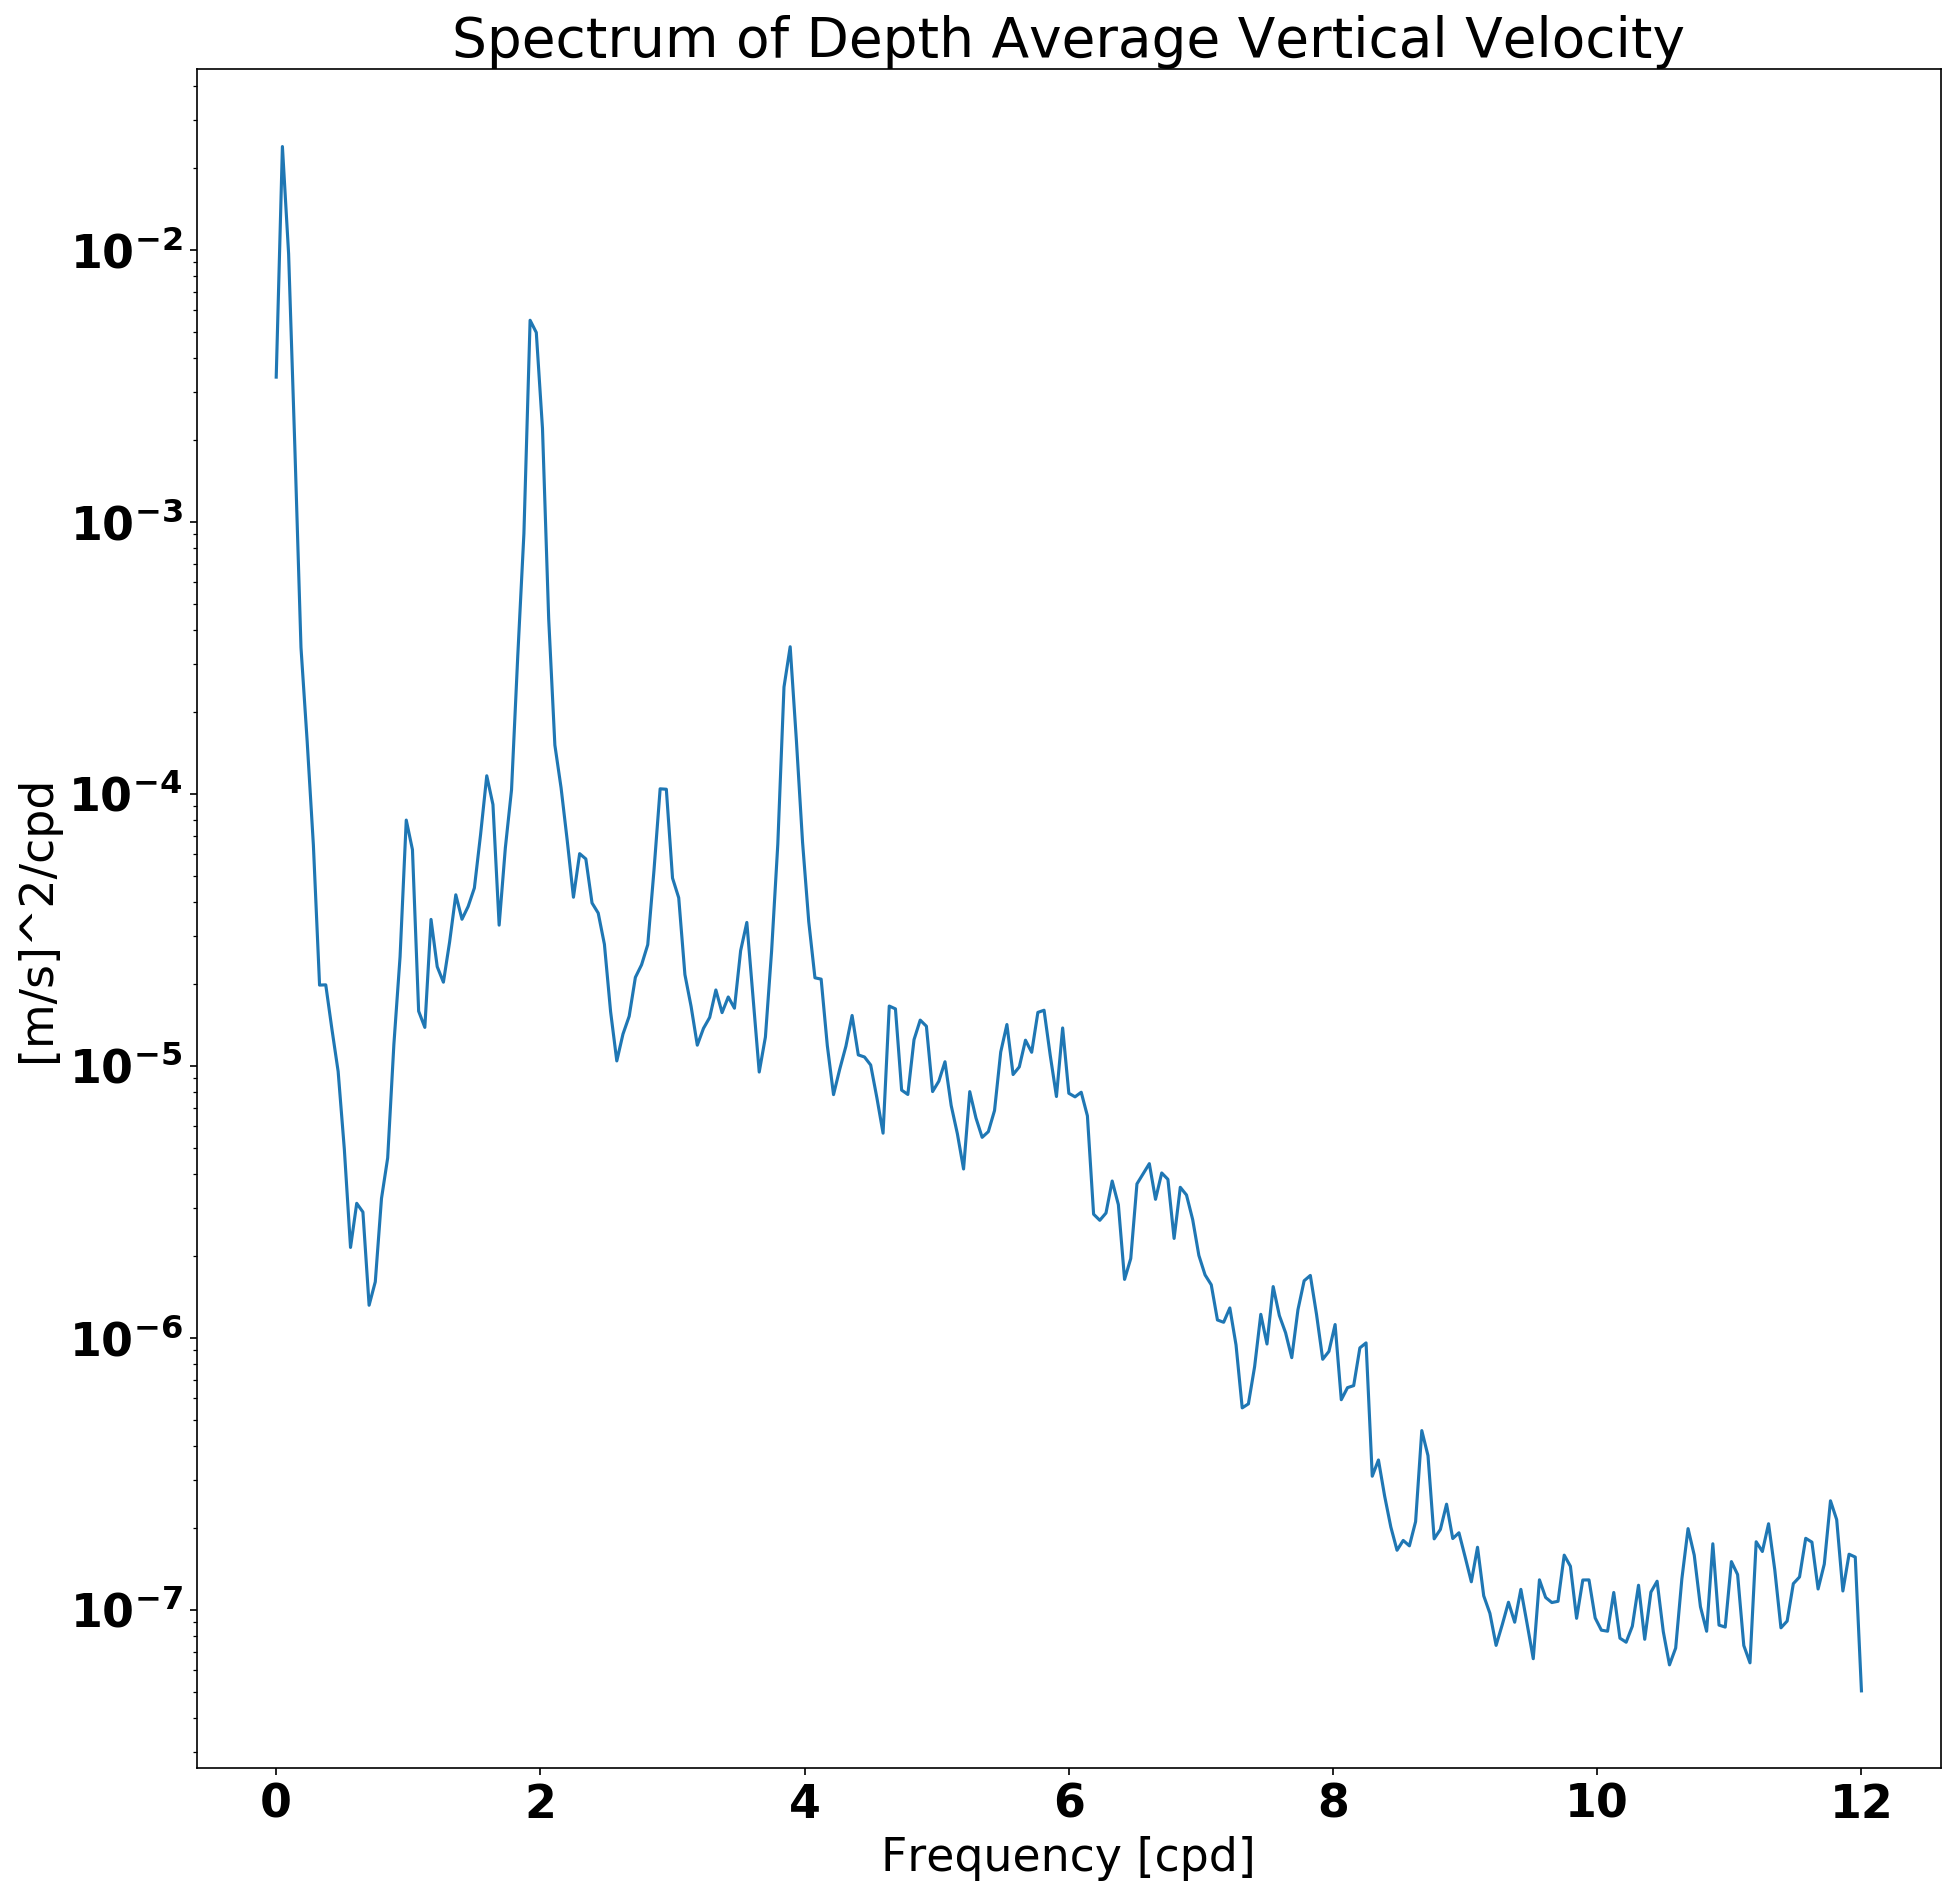

In [12]:
#Depth average time spectrum
W_AVG = W.mean(axis=(1,2,3))
f,pxx = sig.welch(W_AVG,fs=24,nperseg=512)
plt.figure(figsize=(15,15),dpi=150)
plt.semilogy(f,pxx)
plt.xlabel('Frequency [cpd]')
plt.ylabel('[m/s]^2/cpd')
plt.title('Spectrum of Depth Average Vertical Velocity')

(50,)

Text(0.5, 1.0, 'Spectrum of W vs Depth')

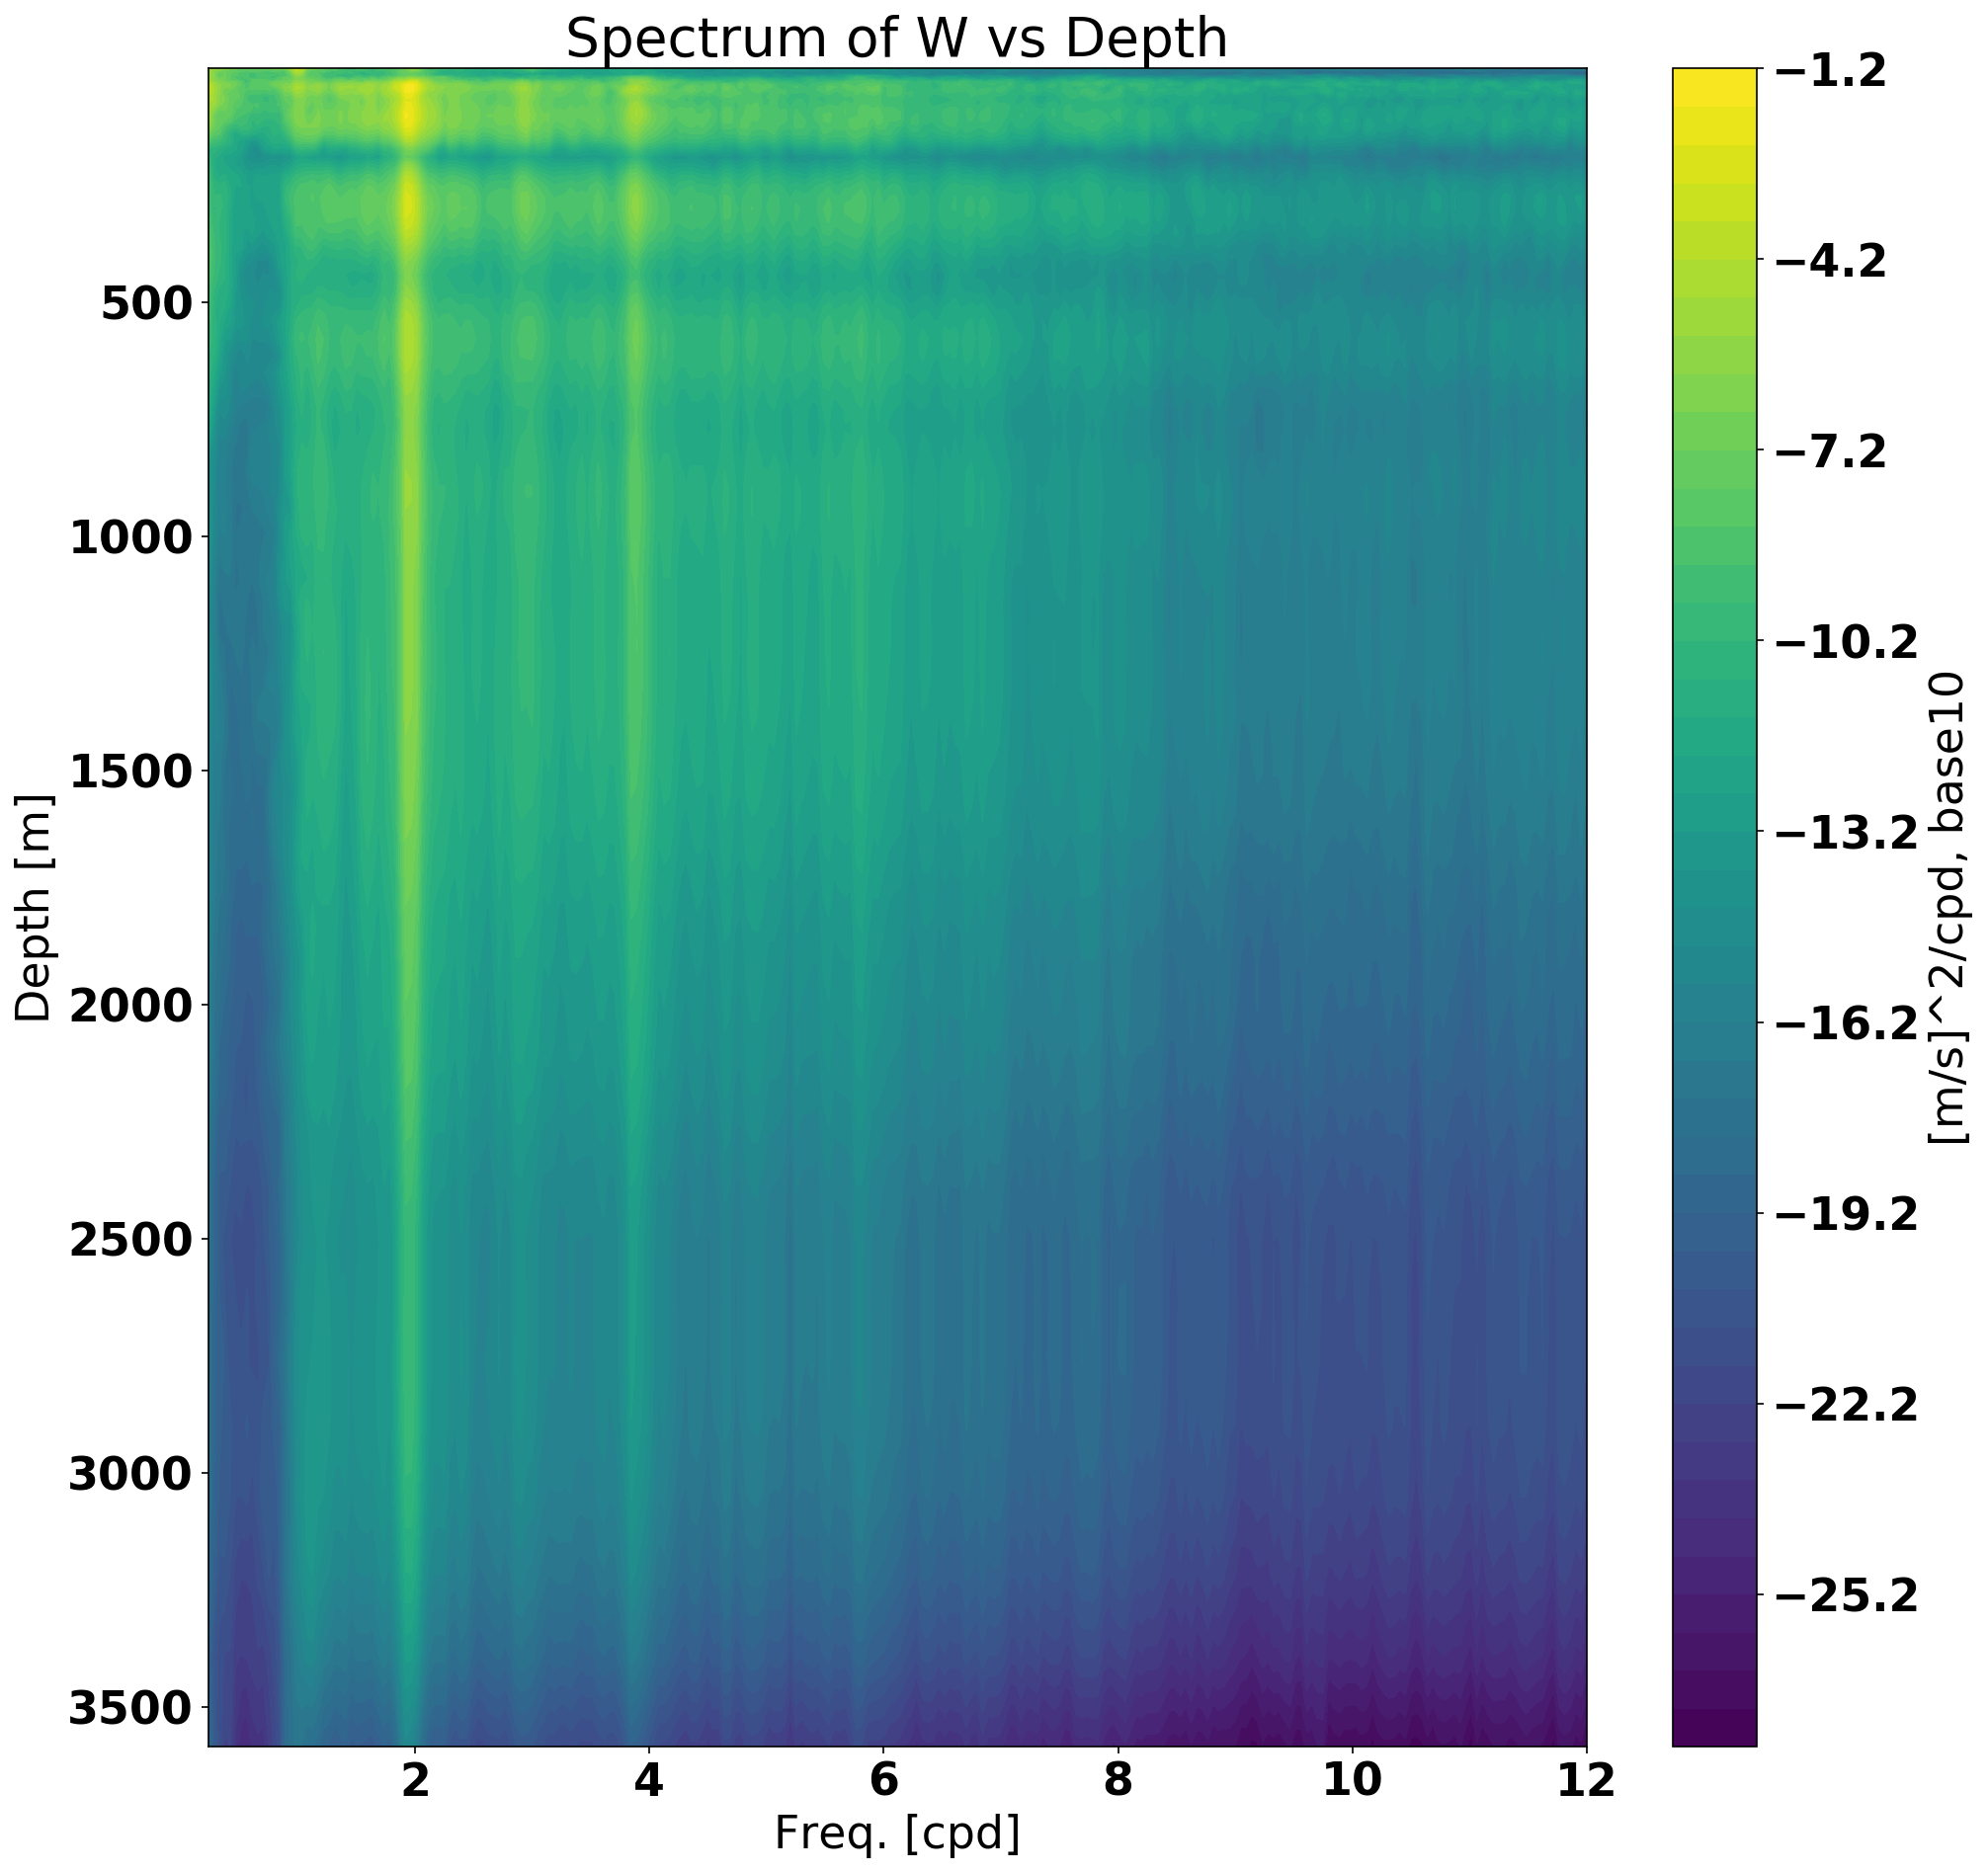

In [13]:
W_SP_AVG = W.mean(axis=(2,3))
f, pxx = sig.welch(W_SP_AVG,fs=24,nperseg=512,axis=(0))
plt.figure(figsize=(15,15),dpi=150)
plt.contourf(f[5:],Z[0:80], np.log(pxx[5:,0:80].T),levels=50)
plt.gca().invert_yaxis()
plt.xlabel('Freq. [cpd]')
plt.ylabel('Depth [m]')
plt.colorbar(label='[m/s]^2/cpd, base10')
plt.title('Spectrum of W vs Depth')

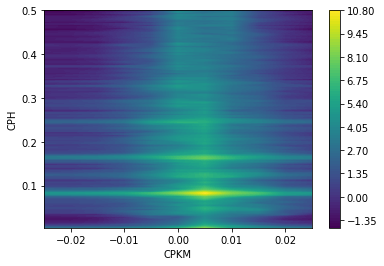

In [7]:
#%matplotlib widget
import COR.utils as cor
#Compute 2D power spectra
#DZ_AVG = DZ.mean(axis=(1,3))
DZ_AVG = DZ[:,30,1,:]
RF_SEG,CF_SEG,D_SPEC = cor.psd_2D(DZ_AVG,SEGS=(10,1),FS=(1,1/20))
f , ax  = plt.subplots()
p = ax.contourf(CF_SEG.T,RF_SEG.T,np.log(D_SPEC.T) ,levels=100)
ax.set_xlabel('CPKM')
ax.set_ylabel('CPH')
f.colorbar(p)